In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **CARREGAMENTO DO DATASET**

In [ ]:
cnpj_final_tratado = pd.read_csv('/content/drive/MyDrive/TCC - PUC/cnpj_final_tratado.csv',encoding='ISO-8859-1', sep=';' , header=0)

In [4]:
cnpj_final_tratado.shape

(10534042, 33)

In [5]:
cnpj_final_tratado.head()

,capital_social,capital_social_faixas,data_situacao_cadastral_ano_mes,situacao_cadastral_target,casosAcumulado_covid,obitosAcumulado_covid,casos_acumulados_porcentagem_covid,obitos_acumulados_porcentagem_covid,casos_acumulados_porcentagem_covid_faixas,obitos_acumulados_porcentagem_covid_faixas,idh_municipio,idh_educacao,idh_longevidade,idh_renda,idh_municipios_faixas,idh_educacao_municipios_faixas,idh_longevidade_municipios_faixas,idh_renda_municipios_faixas,pib_per_capita,pib_per_capita_faixas,idh_municipios_faixas_graf,idh_educacao_municipios_faixas_graf,idh_longevidade_municipios_faixas_graf,idh_renda_municipios_faixas_graf,matriz_filial_2,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,interior_metropolitana_1,le_estado,le_cnae_divisao,le_cnae_secao
0,3500.0,1,202005,1,199.0,9.0,0.029,0.001,0,0,0.789,0.716,0.776,0.885,7,7,7,8,54801.25,7,7,7,7,8,0,0,0,1,0,0,10,83,18
1,3000.0,1,202006,1,38960.0,4716.0,0.580,0.070,5,2,0.799,0.719,0.840,0.845,7,7,8,8,54426.08,7,7,7,8,8,0,0,0,1,0,1,18,74,15
2,10000.0,2,202012,1,1038.0,26.0,5.469,0.137,14,3,0.687,0.564,0.686,0.838,6,5,6,8,28312.72,4,6,5,6,8,0,0,0,0,1,0,17,42,6
3,5000.0,1,202105,1,13239.0,354.0,10.893,0.291,18,7,0.759,0.705,0.735,0.845,7,7,7,8,27802.88,4,7,7,7,8,0,0,0,1,0,0,25,8,2
4,100000.0,6,202009,1,24446.0,926.0,1.648,0.062,7,2,0.805,0.702,0.867,0.857,8,7,8,8,52149.66,7,8,7,8,8,0,0,0,0,1,1,22,75,16


In [6]:
cnpj_final_tratado.dtypes

capital_social                                float64
capital_social_faixas                           int64
data_situacao_cadastral_ano_mes                 int64
situacao_cadastral_target                       int64
casosAcumulado_covid                          float64
obitosAcumulado_covid                         float64
casos_acumulados_porcentagem_covid            float64
obitos_acumulados_porcentagem_covid           float64
casos_acumulados_porcentagem_covid_faixas       int64
obitos_acumulados_porcentagem_covid_faixas      int64
idh_municipio                                 float64
idh_educacao                                  float64
idh_longevidade                               float64
idh_renda                                     float64
idh_municipios_faixas                           int64
idh_educacao_municipios_faixas                  int64
idh_longevidade_municipios_faixas               int64
idh_renda_municipios_faixas                     int64
pib_per_capita              

#**DEFININDO OS DATASETS COM AS VARIÁVEIS EXPLICATIVAS E VARIÁVEL ALVO**

In [7]:
cnpj_final_explicativas = cnpj_final_tratado.drop(columns=['situacao_cadastral_target'])
cnpj_final_alvo = cnpj_final_tratado['situacao_cadastral_target']

In [8]:
cnpj_final_explicativas.head()

,capital_social,capital_social_faixas,data_situacao_cadastral_ano_mes,casosAcumulado_covid,obitosAcumulado_covid,casos_acumulados_porcentagem_covid,obitos_acumulados_porcentagem_covid,casos_acumulados_porcentagem_covid_faixas,obitos_acumulados_porcentagem_covid_faixas,idh_municipio,idh_educacao,idh_longevidade,idh_renda,idh_municipios_faixas,idh_educacao_municipios_faixas,idh_longevidade_municipios_faixas,idh_renda_municipios_faixas,pib_per_capita,pib_per_capita_faixas,idh_municipios_faixas_graf,idh_educacao_municipios_faixas_graf,idh_longevidade_municipios_faixas_graf,idh_renda_municipios_faixas_graf,matriz_filial_2,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,interior_metropolitana_1,le_estado,le_cnae_divisao,le_cnae_secao
0,3500.0,1,202005,199.0,9.0,0.029,0.001,0,0,0.789,0.716,0.776,0.885,7,7,7,8,54801.25,7,7,7,7,8,0,0,0,1,0,0,10,83,18
1,3000.0,1,202006,38960.0,4716.0,0.580,0.070,5,2,0.799,0.719,0.840,0.845,7,7,8,8,54426.08,7,7,7,8,8,0,0,0,1,0,1,18,74,15
2,10000.0,2,202012,1038.0,26.0,5.469,0.137,14,3,0.687,0.564,0.686,0.838,6,5,6,8,28312.72,4,6,5,6,8,0,0,0,0,1,0,17,42,6
3,5000.0,1,202105,13239.0,354.0,10.893,0.291,18,7,0.759,0.705,0.735,0.845,7,7,7,8,27802.88,4,7,7,7,8,0,0,0,1,0,0,25,8,2
4,100000.0,6,202009,24446.0,926.0,1.648,0.062,7,2,0.805,0.702,0.867,0.857,8,7,8,8,52149.66,7,8,7,8,8,0,0,0,0,1,1,22,75,16


In [9]:
cnpj_final_alvo.head()

0    1
1    1
2    1
3    1
4    1
Name: situacao_cadastral_target, dtype: int64

#  **PROCESSO DE SELEÇÃO DAS MELHORES VARIÁVEIS PARA O MODELO**

## **Filtro**
Este método avalia os atributos individualmente
usando a medida χ2 com relação à classe

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [11]:
chi_selector = SelectKBest(chi2,
                           k=5) # define o número de variáveis selecionadas no filtro
chi_selector

SelectKBest(k=5, score_func=<function chi2 at 0x7f752b810c20>)

In [12]:
chi_selector.fit(cnpj_final_explicativas, cnpj_final_alvo)

SelectKBest(k=5, score_func=<function chi2 at 0x7f752b810c20>)

In [13]:
chi_support  = chi_selector.get_support()
chi_feature = cnpj_final_explicativas.loc[:,chi_support].columns.tolist()
print(' Variávei selecionadas:')
print(chi_feature)

 Variávei selecionadas:
['capital_social', 'casosAcumulado_covid', 'obitosAcumulado_covid', 'casos_acumulados_porcentagem_covid', 'casos_acumulados_porcentagem_covid_faixas']


##  **Wrapper (Empacotado)**
Este método utiliza regressão logística para seleção de variáveis. O processo de escolha do subconjunto de atributos está “empacotado” junto com o algoritmo
de aprendizado sendo utilizado

In [14]:
from sklearn.feature_selection import RFE  
from sklearn.linear_model import LogisticRegression

rfe_selector = RFE(estimator=LogisticRegression(random_state=69),
                  step=10,
                  n_features_to_select=5)
rfe_selector.fit(cnpj_final_explicativas, cnpj_final_alvo)
rfe_support = rfe_selector.get_support()
rfe_feature = cnpj_final_explicativas.loc[:,rfe_support].columns.tolist()

print('Variáveis selecionadas:')
print(rfe_feature)

Variáveis selecionadas:
['data_situacao_cadastral_ano_mes', 'casosAcumulado_covid', 'obitosAcumulado_covid', 'casos_acumulados_porcentagem_covid_faixas', 'pib_per_capita']


## **Embedded (Embutido)**
Determinação de relevância. Este método usa RandomForest para selecionar as variáveis

In [15]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

emb_selector = SelectFromModel(RandomForestClassifier(random_state=42))
emb_selector.fit(cnpj_final_explicativas, cnpj_final_alvo)
emb_support = emb_selector.get_support()
emb_feature = cnpj_final_explicativas.loc[:,emb_support].columns.tolist()

print('Variáveis selecionadas:')
print(emb_feature)

Variáveis selecionadas:
['capital_social', 'data_situacao_cadastral_ano_mes', 'casosAcumulado_covid', 'obitosAcumulado_covid', 'casos_acumulados_porcentagem_covid', 'obitos_acumulados_porcentagem_covid', 'casos_acumulados_porcentagem_covid_faixas', 'obitos_acumulados_porcentagem_covid_faixas', 'idh_municipio', 'idh_longevidade', 'le_cnae_divisao']


## **Ranking das variáveis selecionadas**

In [16]:
ranking_variaveis = pd.DataFrame({'Número e Nome da Variável': cnpj_final_explicativas.columns,
                                    'Chi-2':chi_support, 
                                    'Recursive Feature Elimination': rfe_support, 
                                    'RandomForest':emb_support}) 
ranking_variaveis['Total de Verdadeiros'] = np.sum(ranking_variaveis, axis=1)                                     
ranking_variaveis = ranking_variaveis.sort_values(['Total de Verdadeiros','Número e Nome da Variável'], ascending=False)
ranking_variaveis

,Número e Nome da Variável,Chi-2,Recursive Feature Elimination,RandomForest,Total de Verdadeiros
4,obitosAcumulado_covid,True,True,True,3
7,casos_acumulados_porcentagem_covid_faixas,True,True,True,3
3,casosAcumulado_covid,True,True,True,3
2,data_situacao_cadastral_ano_mes,False,True,True,2
5,casos_acumulados_porcentagem_covid,True,False,True,2
0,capital_social,True,False,True,2
17,pib_per_capita,False,True,False,1
8,obitos_acumulados_porcentagem_covid_faixas,False,False,True,1
6,obitos_acumulados_porcentagem_covid,False,False,True,1
30,le_cnae_divisao,False,False,True,1


# **CRIAÇÃO DE DATAFRAME COM VARIAVEIS SELECIONADAS**

In [17]:
explicativas = cnpj_final_explicativas[['obitosAcumulado_covid', 'casos_acumulados_porcentagem_covid_faixas', 'casosAcumulado_covid','data_situacao_cadastral_ano_mes','casos_acumulados_porcentagem_covid','capital_social']]
explicativas.head()

,obitosAcumulado_covid,casos_acumulados_porcentagem_covid_faixas,casosAcumulado_covid,data_situacao_cadastral_ano_mes,casos_acumulados_porcentagem_covid,capital_social
0,9.0,0,199.0,202005,0.029,3500.0
1,4716.0,5,38960.0,202006,0.580,3000.0
2,26.0,14,1038.0,202012,5.469,10000.0
3,354.0,18,13239.0,202105,10.893,5000.0
4,926.0,7,24446.0,202009,1.648,100000.0


# **SEPARAÇÃO DOS DATASETS EM TREINO E TESTE**

In [18]:
from sklearn.model_selection import train_test_split 
x_treino, x_teste, y_treino, y_teste = train_test_split(explicativas, cnpj_final_alvo, test_size=0.3, random_state=69)

# **GERAÇÃO DOS MODELOS**

## **Logistic Regression**

**Normalização dos Dados**

In [19]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_treino = sc.fit_transform(x_treino)
x_teste = sc.transform(x_teste)

**Aplicação do Modelo**

In [20]:
from sklearn.linear_model import LogisticRegression
rl =LogisticRegression(random_state=69)
rl.fit(x_treino,np.ravel(y_treino,order='C'))
y_predicao=rl.predict(x_teste)

**Vizualização das Métricas**

In [21]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(metrics.classification_report(y_teste, y_predicao, target_names=['0','1']))
print ("Acurácia de Previsão:", accuracy_score(y_teste, y_predicao))
lr_resultado = accuracy_score(y_teste, y_predicao)

              precision    recall  f1-score   support

           0       0.76      0.98      0.86   2338516
           1       0.70      0.14      0.24    821697

    accuracy                           0.76   3160213
   macro avg       0.73      0.56      0.55   3160213
weighted avg       0.75      0.76      0.70   3160213

Acurácia de Previsão: 0.7612420428623007


In [22]:
rl.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 69,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

**Matriz de Confusão**

In [23]:
matriz_confusao =  metrics.confusion_matrix(y_teste, y_predicao)

In [24]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
  

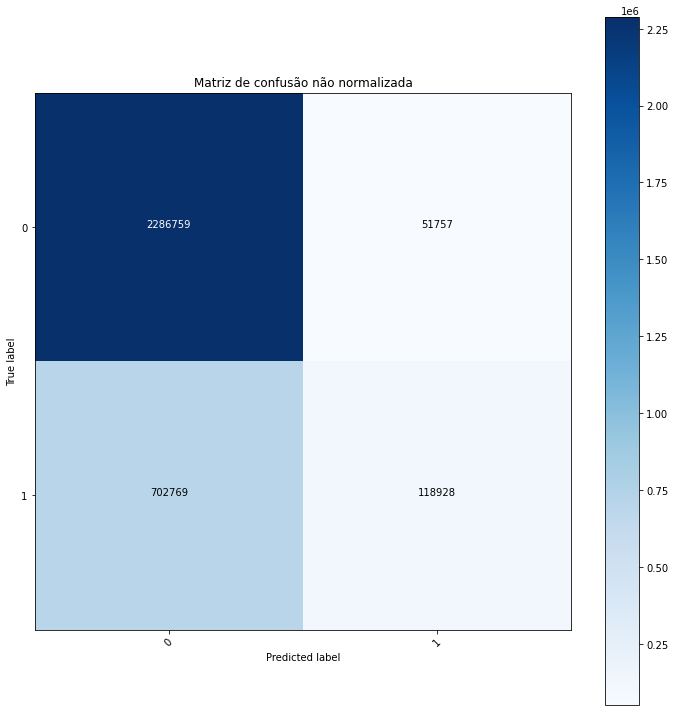

In [25]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(matriz_confusao,classes =['0', '1'], title='Matriz de confusão não normalizada', normalize=False)

## **Random Forest**

**Normalização dos Dados**

In [26]:
sc = StandardScaler()
x_treino = sc.fit_transform(x_treino)
x_teste = sc.transform(x_teste)

**Aplicação do Modelo**

In [27]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=15, min_samples_leaf = 200)
rfc.fit(x_treino,np.ravel(y_treino,order='C'))
y_predicao = rfc.predict(x_teste)

**Vizualização das Métricas**

In [28]:
print(metrics.classification_report(y_teste, y_predicao, target_names=['0','1']))
print ("Acurácia de Previsão:", accuracy_score(y_teste, y_predicao))
rf_resultado = accuracy_score(y_teste, y_predicao)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91   2338516
           1       0.97      0.43      0.60    821697

    accuracy                           0.85   3160213
   macro avg       0.90      0.71      0.75   3160213
weighted avg       0.87      0.85      0.83   3160213

Acurácia de Previsão: 0.8491585851966308


In [29]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 200,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 15,
 'verbose': 0,
 'warm_start': False}

**Matriz de Confusão**

In [30]:
cnf_matrix =  metrics.confusion_matrix(y_teste, y_predicao)

In [31]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


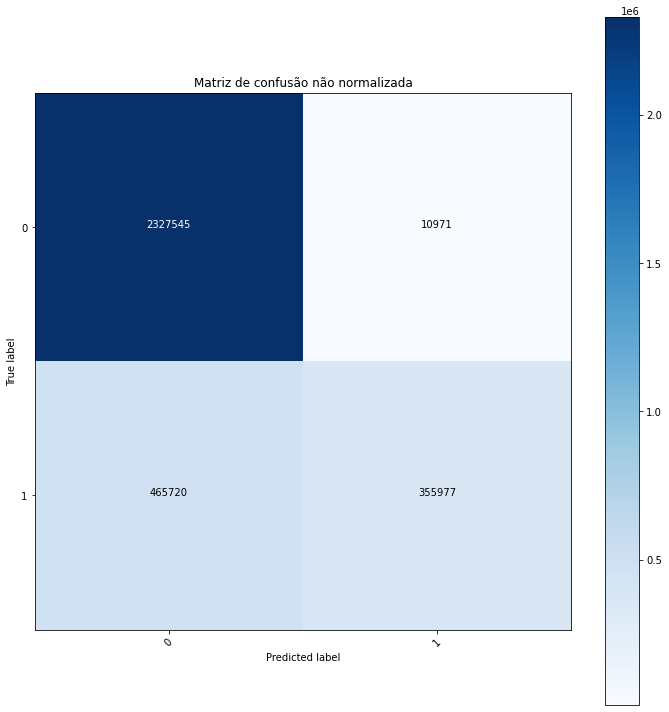

In [32]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix,classes =['0', '1'], title='Matriz de confusão não normalizada', normalize=False)

## **Ranking dos Modelos**

In [33]:
ranking_modelos = pd.DataFrame({
                                 'NOME DO MODELO': ['REGRESSÃO LOGÍSTICA', 'RANDOM FOREST'],
                                 'RESULTADO': [lr_resultado, rf_resultado]})
ranking_modelos

,NOME DO MODELO,RESULTADO
0,REGRESSÃO LOGÍSTICA,0.761242
1,RANDOM FOREST,0.849159
